In [179]:
!pip install ucimlrepo


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [180]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt, ceil, log2
from typing import Optional

## Сборка данных

In [181]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
mushroom = fetch_ucirepo(id=73) 
  
# data (as pandas dataframes) 
X = mushroom.data.features 
y = mushroom.data.targets

X.info()
y.info()

y = y['poisonous']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   cap-shape                 8124 non-null   object
 1   cap-surface               8124 non-null   object
 2   cap-color                 8124 non-null   object
 3   bruises                   8124 non-null   object
 4   odor                      8124 non-null   object
 5   gill-attachment           8124 non-null   object
 6   gill-spacing              8124 non-null   object
 7   gill-size                 8124 non-null   object
 8   gill-color                8124 non-null   object
 9   stalk-shape               8124 non-null   object
 10  stalk-root                5644 non-null   object
 11  stalk-surface-above-ring  8124 non-null   object
 12  stalk-surface-below-ring  8124 non-null   object
 13  stalk-color-above-ring    8124 non-null   object
 14  stalk-color-below-ring  

## Quick and dirty fillna
Видим, что в признаке stalk-root есть пустые значения, заполним модой.

In [182]:
X["stalk-root"].fillna(X["stalk-root"].mode()[0], inplace=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   cap-shape                 8124 non-null   object
 1   cap-surface               8124 non-null   object
 2   cap-color                 8124 non-null   object
 3   bruises                   8124 non-null   object
 4   odor                      8124 non-null   object
 5   gill-attachment           8124 non-null   object
 6   gill-spacing              8124 non-null   object
 7   gill-size                 8124 non-null   object
 8   gill-color                8124 non-null   object
 9   stalk-shape               8124 non-null   object
 10  stalk-root                8124 non-null   object
 11  stalk-surface-above-ring  8124 non-null   object
 12  stalk-surface-below-ring  8124 non-null   object
 13  stalk-color-above-ring    8124 non-null   object
 14  stalk-color-below-ring  

C:\Users\dmitr\AppData\Local\Temp\ipykernel_3660\4246288932.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["stalk-root"].fillna(X["stalk-root"].mode()[0], inplace=True)


## Визуализация

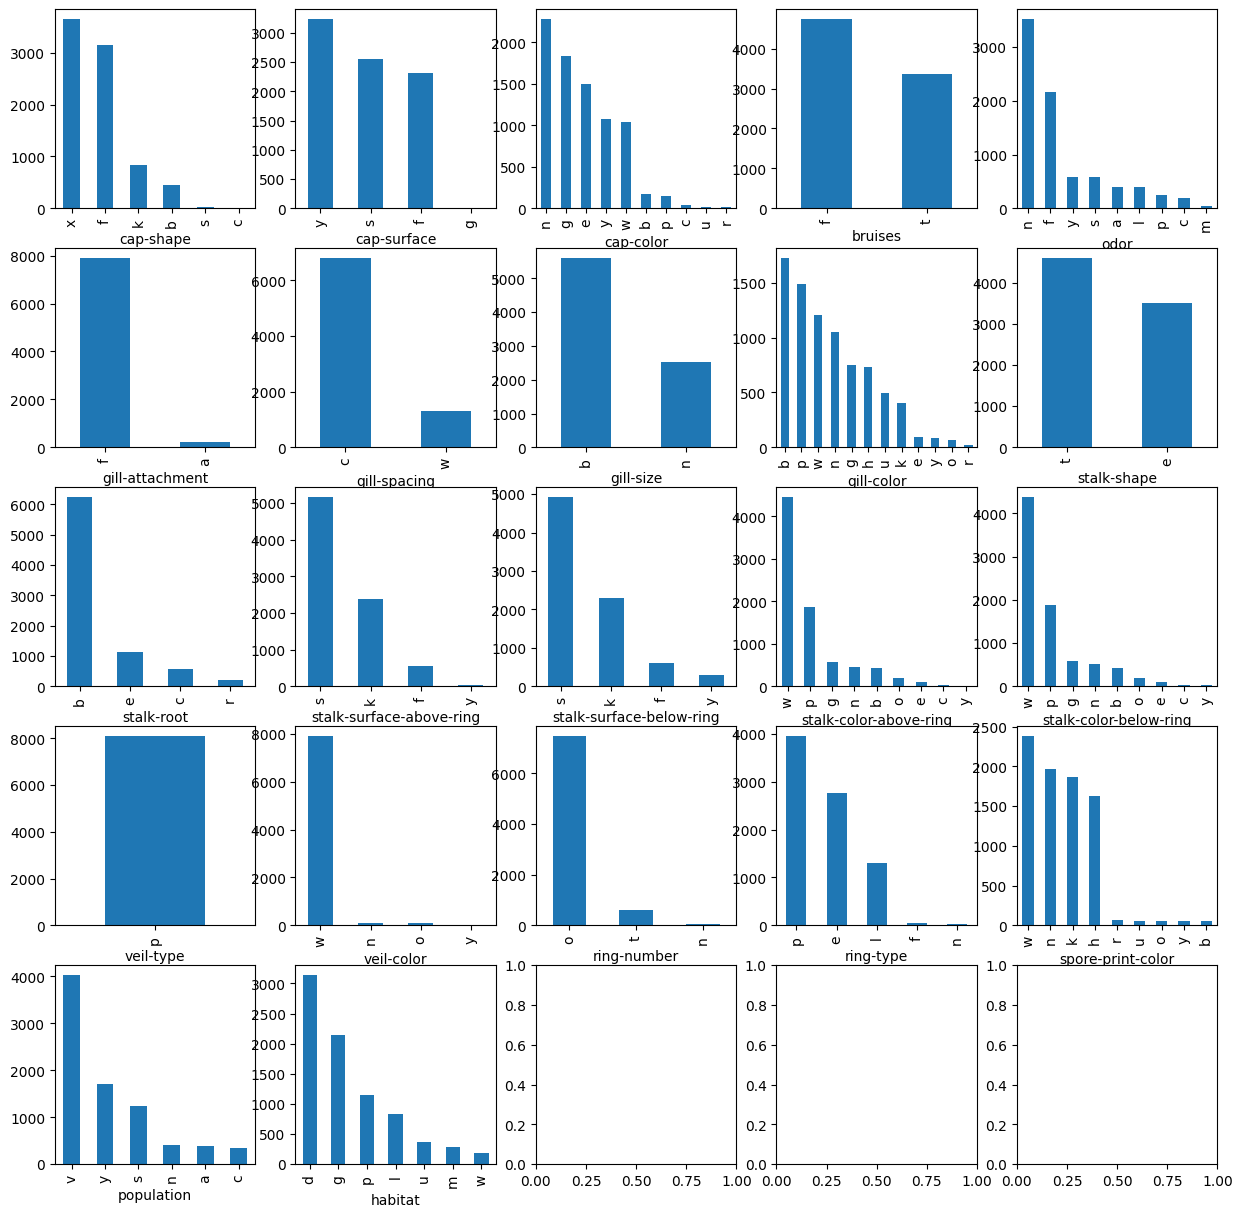

In [183]:
fig, axs = plt.subplots(ceil(sqrt(len(X.columns))), ceil(sqrt(len(X.columns))))
for ax, col in zip(axs.flatten(), X.columns):
    X[col].value_counts().plot(kind="bar", ax=ax)
fig.set_figheight(15)
fig.set_figwidth(15)

<Axes: xlabel='poisonous'>

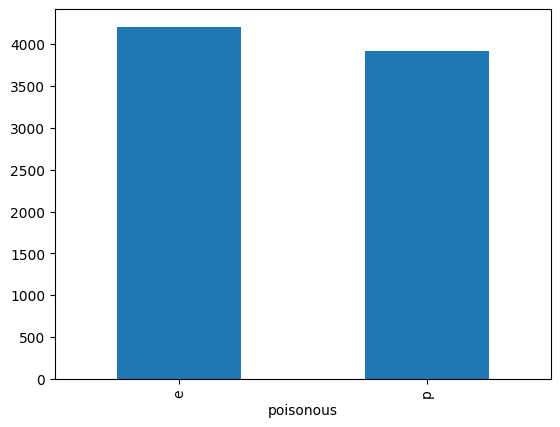

In [184]:
y.value_counts().plot(kind="bar")

## Decision Tree 

In [185]:
class Node:
    def __init__(
        self, 
        feature_name: str,
        value_to_node: dict[str, 'Node']
    ):
        self.feature_name = feature_name
        self.value_to_node = value_to_node

    def pred(self, x):
        feature_value = x[self.feature_name]
        if feature_value not in self.value_to_node:
            return None
        return self.value_to_node[feature_value].pred(x)

    def pred_prob(self, x):
        feature_value = x[self.feature_name]
        if feature_value not in self.value_to_node:
            return 0
        return self.value_to_node[feature_value].pred_prob(x)

    def print_node(self, indent=0):
        for value, node in self.value_to_node.items():
            print(' ' * indent + f'{self.feature_name} == {value}:')
            node.print_node(indent+2)

class LeafNode(Node):
    def __init__(
        self,
        leaf_value: str,
        prob: float
    ):
        super().__init__("", {})
        self.leaf_value = leaf_value
        self.prob = prob

    def pred(self, x):
        return self.leaf_value

    def pred_prob(self, x):
        return (self.leaf_value, self.prob)

    def print_node(self, indent=0):
        print(' ' * indent + f'-> {self.leaf_value} ({self.prob})')

class DecisionTree:
    def __init__(self, cols: list[str]):
        self.cols = cols

    def fit(self, x, y):
        self.root = self._build_node(x[self.cols], y, DecisionTree._entropy(y))

    def pred(self, x):
        res = []
        for row in x[self.cols].to_records():
            res.append(self.root.pred(row))
        return res

    def pred_prob(self, x):
        res = []
        for row in x[self.cols].to_records():
            res.append(self.root.pred_prob(row))
        return res

    def _build_node(self, x, y, parent_info: float) -> Node:
        if len(y.unique()) == 1:
            return LeafNode(y.unique()[0], 1)

        best_gain = 0
        best_gain_info = 0
        best_gain_col = ''
        
        for col in self.cols:
            cat_names = x[col].unique()
            info = 0
            
            for cat in cat_names:
                cat_weight = x[col].value_counts()[cat] / len(x)
                entropy = DecisionTree._entropy(y[x[col] == cat])
                info += cat_weight * entropy

            if parent_info - info > best_gain:
                best_gain = parent_info - info
                best_gain_info = info
                best_gain_col = col

        if best_gain_col == '':
            mode = y.mode()[0]
            return LeafNode(mode, y.value_counts()[mode] / len(y))

        values_to_node = {}

        cat_names = x[best_gain_col].unique()
        for cat in cat_names:
            values_to_node[cat] = self._build_node(x[x[best_gain_col] == cat], y[x[best_gain_col] == cat], best_gain_info)

        return Node(best_gain_col, values_to_node)

    def print_tree(self):
        self.root.print_node()

    @staticmethod
    def _entropy(y) -> float:
        cls_names = y.unique()
        res = 0

        for cls in cls_names:
            cls_prob = y.value_counts()[cls] / len(y)
            res -= cls_prob * log2(cls_prob)
        
        return res


## Train-Test-Split

In [186]:
samples_amount = 0.3
random_state = 336771

test_x = X.sample(frac=samples_amount, random_state=random_state)
test_y = y[test_x.index]
train_x = X.drop(test_x.index, axis=0)
train_y = y[train_x.index]

## Training

In [187]:
cols = X.columns
cols = np.random.choice(cols, ceil(sqrt(len(cols))))

print("Используются признаки:", *cols)

tree = DecisionTree(cols)
tree.fit(train_x, train_y)
tree.print_tree()

Используются признаки: cap-color stalk-color-below-ring population ring-type stalk-shape
ring-type == p:
  cap-color == y:
    -> e (1)
  cap-color == w:
    -> e (0.5917602996254682)
  cap-color == g:
    population == y:
      -> e (1)
    population == v:
      -> e (0.8007246376811594)
    population == s:
      -> p (0.5363636363636364)
    population == n:
      -> e (1)
  cap-color == n:
    population == s:
      -> p (0.5714285714285714)
    population == v:
      stalk-color-below-ring == w:
        -> e (0.6384615384615384)
      stalk-color-below-ring == g:
        -> e (1)
      stalk-color-below-ring == p:
        -> e (1)
      stalk-color-below-ring == o:
        -> e (1)
    population == y:
      -> e (1)
    population == c:
      -> e (1)
  cap-color == e:
    -> e (1)
  cap-color == p:
    population == s:
      -> p (1)
    population == v:
      -> p (0.9090909090909091)
    population == y:
      -> e (1)
  cap-color == b:
    -> p (1)
  cap-color == c:
    -> e

## Testing

### Metrics
Мы будем использовать E как положительный признак, P - как отрицательный

In [204]:
def confusion_matrix(pred_y, true_y):
    res = np.zeros((2, 2))

    for pred, true in zip(pred_y, true_y):
        pred = 1 if pred == 'e' else 0
        true = 1 if true == 'e' else 0
        res[pred][true] += 1
    
    return res

def confusion_matrix_prob(pred_probs, true_y, threshold):
    res = np.zeros((2, 2))

    for pred_prob, true in zip(pred_probs, true_y):
        pred = 1 if pred_prob >= threshold else 0
        true = 1 if true == 'e' else 0
        res[pred][true] += 1

    return res

def accuracy(conf):
    return (conf[1][1] + conf[0][0]) / sum(conf.flatten())

def precision(conf):
    return conf[1][1] / (conf[1][1] + conf[1][0])

def recall(conf):
    return conf[1][1] / (conf[1][1] + conf[0][1])

def fallout(conf):
    return conf[1][0] / (conf[1][0] + conf[0][0])


In [202]:
pred_y = tree.pred(test_x)
conf = confusion_matrix(pred_y, test_y)
print(conf)
print('Accuracy:', accuracy(conf))
print('Precision', precision(conf))
print('Recall:', recall(conf))

[[1019.   33.]
 [ 150. 1235.]]
Accuracy: 0.9249076733688962
Precision 0.8916967509025271
Recall: 0.9739747634069401


## AUC
Для ROC и PR

In [203]:
pred_prob = tree.pred_prob(test_x)
probs = []

for i in range(len(pred_prob)):
    pred, prob = pred_prob[i]
    if pred == 'e':
        probs.append(prob)
    else:
        probs.append(1-prob)

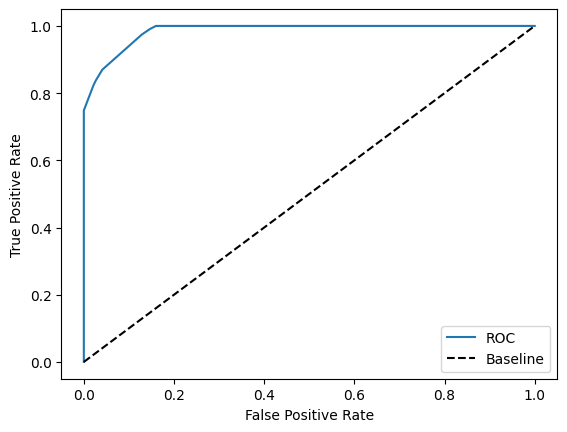

In [223]:
tpr = []
fpr = []

for th in np.arange(1, 0, -0.01):
    conf = confusion_matrix_prob(probs, test_y, th)
    tpr.append(recall(conf))
    fpr.append(fallout(conf))

plt.plot([0] + fpr + [1], [0] + tpr + [1], label='ROC')
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), 'k--', label='Baseline')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

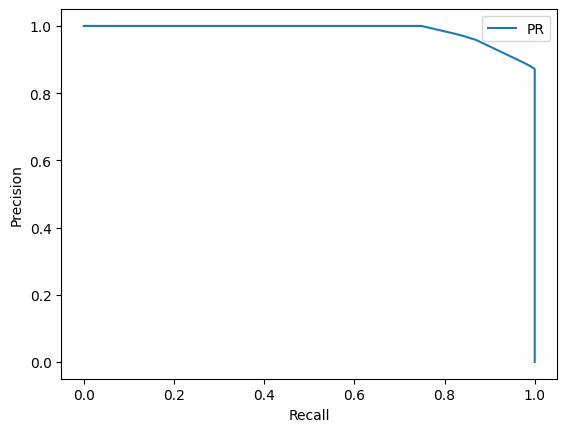

In [227]:
p = []
r = []

for th in np.arange(0, 1, 0.01):
    conf = confusion_matrix_prob(probs, test_y, th)
    p.append(precision(conf))
    r.append(recall(conf))

plt.plot([1] + r + [0], [0] + p + [1], label='PR')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()